
# <h1><center>Brittle Star Environment Tutorial</center></h1>

This notebook provides an introductory tutorial to the [Brittle Star environment](https://github.com/Co-Evolve/brb/tree/new-framework/brb/brittle_star), which is part of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb).

Preferably use a Jupyter runtime with GPU acceleration enabled.  

## The Bio-inspired Robotics Benchmark (BRB)
The Bio-Inspired Robotics Benchmark represents a significant stride in the convergence of robotics and experimental biology, offering a unique platform that leverages the MuJoCo physics simulator to create a collection of bio-inspired robotics simulation environments. This initiative is more than just a technical tool; it serves as a crucible for cross-disciplinary dialogue and innovation, uniting two fields that, while distinct, share a common goal of understanding and emulating complex biological systems.

In the realm of robotics, this benchmark addresses a pivotal challenge: the design and control of bio-inspired robots. These robots, inspired by the intricacies of biological organisms, present novel hurdles that contemporary optimization methodologies struggle to surmount. By providing a benchmark specifically tailored to these challenges, the initiative not only facilitates the validation of existing methodologies but also catalyzes the development of new approaches. This is crucial for advancing the field, as it pushes the boundaries of what we can achieve in robotic design and control, drawing inspiration from the most sophisticated systems found in nature.

On the biological front, the application of robotics serves as a powerful comparative method. It offers a more controlled environment for conducting comparative studies, essential for dissecting complex behaviors, ecological interactions, and the evolutionary histories of organisms. In essence, robotics becomes a lens through which biologists can observe and understand the myriad of interacting elements that constitute life's diversity. This perspective is invaluable, as it transcends traditional observational methods, allowing for more precise and insightful analyses.

Overall, the Bio-Inspired Robotics Benchmark is a testament to the symbiotic potential of robotics and biology. It not only advances our technical capabilities in creating machines that mimic life but also deepens our understanding of the biological phenomena that inspire these creations. This benchmark is a stepping stone towards a future where the interplay between robotics and biology yields innovations that are as profound as they are transformative. 


The Bio-Inspired Robotics Benchmark distinguishes itself with its capability to effortlessly simulate various morphological variations of bio-inspired robots. This flexibility is largely enabled by the use of the [Framework for Parameterized Robot Specifications (FPRS)](https://github.com/Co-Evolve/fprs), a framework that centralizes the adaptable definition of a robot's morphology. In FPRS, a 'Specification' acts as a comprehensive bundle, encapsulating all the modifiable parameters that define the robot's form and structure. This approach to morphology parameterization not only simplifies the modification process but also enhances the reproducibility and comparability of different morphological setups within the BRB.

The implementation of environments within the BRB adheres to framework defined in the [mujoco-utils package](https://github.com/Co-Evolve/mujoco-utils/tree/new-framework). This framework defines an environment as a combination of a parameterized morphology, as defined by FPRS, and a configurable arena. Both the morphology and the arena in this context are essentially generators for MJCF (MuJoCo XML) files, allowing for dynamic and customizable environment creation. This design philosophy ensures that each environment within the BRB is both flexible and specific to the needs of the experiment at hand.

Furthermore, the BRB environments are designed to be compatible with the [Gymnasium interface](https://gymnasium.farama.org/content/basic_usage/). This compatibility is significant as it allows for seamless integration with a wide range of existing machine learning and robotics research tools, fostering ease of use and accessibility for researchers from various fields.

In terms of simulation capabilities, the BRB offers environments in both native MuJoCo and MuJoCo XLA (MJX) formats. This dual availability caters to diverse computational needs and preferences, ensuring that researchers can select the simulation environment that best suits their specific requirements, whether it's the high-fidelity physics of native MuJoCo or the accelerated computation offered by MuJoCo XLA.

In summary, the BRB's unique approach to morphology parameterization through FPRS, adherence to the mujoco-utils framework for environment implementation, compatibility with the gymnasium interface, and availability in both MuJoCo and MJX formats, collectively contribute to its status as a versatile and powerful tool for bio-inspired robotics research. This tool not only facilitates a deeper exploration of robotic morphologies but also bridges the gap between theoretical research and practical application in the field of bio-inspired robotics.

### BRB installation

Before continuing, check if the following points towards your conda environment. If not, follow these [steps](https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084).

In [1]:
import sys

print(sys.executable)

/Users/driesmarzougui/miniforge3/envs/SEL3-2024/bin/python


Install the BRB package and its dependencies.

In [2]:
try:
    import brb
except ImportError:
    !{sys.executable} -m pip install git+https://github.com/Co-Evolve/brb@new-framework

Check if the underlying MuJoCo installation was successful. This will also check if Jax is able to find the GPU. If not, a warning will be printed.

In [3]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Checking that the mujoco installation succeeded:
MuJoCo installation successful.


Some packages and utility functions for visualization.

In [4]:
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from mujoco_utils.mjcf_utils import MJCFRootComponent
import numpy as np
import jax.numpy as jnp
from typing import Union, List

# Graphics and plotting.
print('Installing mediapy:')
ffmpeg_v = !command -v ffmpeg
assert "command not found" not in ffmpeg_v, f"Please install FFmpeg for visualizations."
!{sys.executable} -m pip install -q mediapy
import mediapy as media

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
jnp.set_printoptions(precision=3, suppress=True, linewidth=100)

def visualize_mjcf(
        mjcf: MJCFRootComponent
        ) -> None:
    model = mujoco.MjModel.from_xml_string(mjcf.get_mjcf_str())
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())


def post_environment_render(
        render_output: Union[np.ndarray, List[np.ndarray]],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if len(environment_configuration.camera_ids) > 1:
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in render_output]

    return render_output[:, :, ::-1]  # RGB to BGR

Installing mediapy:


## The Brittle Star Environment
> “The whole of the brittle stars are curious and restless beings. They can never remain in the same attitude for the tenth part of a second, but are constantly twisting their long arms, as if they were indeed the serpents with which Medusa’s head was surrounded.” -- J. G. Wood, 1898

The Brittle Star Robot environment within the Bio-Inspired Robotics Benchmark (BRB) presents an intriguing case study, embodying the intersection of natural biological systems and robotic engineering. To introduce this environment, it's essential to first understand the biological entity that inspired it: the brittle star.

TODO: image of brittle stars species
(Image src: https://doi.org/10.1016/j.jsb.2020.107481)

### The Brittle Star
Brittle stars, belonging to the class Ophiuroidea, are remarkable echinoderms distinguished by their distinctively slender arms and central disk. They inhabit various marine environments, showcasing a fascinating array of behaviors and adaptations that have captivated biologists for decades. One of the most striking features of brittle stars is their locomotion. Unlike their close relatives, the starfish, brittle stars move with a unique, elegant undulating motion of their arms. This locomotion is not only efficient but also highly adaptable, allowing them to navigate complex underwater terrains with agility and precision.

In addition to locomotion, brittle stars use their arms to hold onto substrates, coiling their flexible arms tightly around structurally complex objects such as kelp, sponges, or corals, with spines located along the arms aiding in the anchoring process.

From an evolutionary standpoint, brittle stars represent a significant lineage, offering insights into the adaptability and resilience of marine life. Their ability to regenerate lost limbs and their sensory capabilities, which include responding to light without distinct eyes, are just a few examples of their remarkable biological traits. These characteristics make them an excellent subject for bio-inspired robotics, as they provide a template for designing robots that are both flexible and resilient, capable of navigating and adapting to diverse environments.

#### Morphology

todo add image: arm anatomy
(Image src: https://doi.org/10.1016/j.jsb.2020.107481) 

At the core of a brittle star's anatomy is the central disk, which varies in size from as small as 3mm to as large as 50mm. This disk is not just a structural component but also serves as a crucial hub for the organism's nervous system and, in some species, reproductive organs. 

Brittle stars possess five arms that are symmetrically arranged in a pentaradial fashion around the central disk. This pentaradial symmetry is a hallmark of echinoderms and is crucial for the brittle star's locomotion and interaction with its environment. These arms typically span about two to twenty times the diameter of the central disk. In terms of mobility, the arms of brittle stars are capable of both in-plane and out-of-plane bending.

Structurally, each arm consists of a chain of segments, each one consisting out of a vertebra and 4 muscle groups and completely enclosed by plates. This skeletal structure provides both support and flexibility, enabling the arms to move fluidly while maintaining structural integrity.

todo add image: brittle_stars_muscles.jpg
(Image src: https://doi.org/10.3389/fnbot.2019.00104)

Lastly, the arms of brittle stars are adorned with soft spines. These spines play a crucial role in anchoring and interacting with the environment. They provide stability and traction on various surfaces, aiding in locomotion and foraging activities.

#### Nervous system
todo add image: nervous system
(Image src: http://dx.doi.org/10.3389/fnbot.2019.00066)

The nervous system of the brittle star is a fascinating aspect of its biology, characterized by its decentralized nature. This decentralized nervous system is quite different from the central nervous systems found in vertebrates and even some invertebrates. In brittle stars, the nervous system is primarily composed of a nerve ring that encircles the central disk, from which branches extend into each arm.

The nerve ring acts as a central hub, integrating sensory inputs and coordinating the movements of the arms. Unlike centralized nervous systems where a brain or a similar central organ exerts control, the nerve ring in brittle stars does not function as a central command center. Instead, it serves more as a conduit or a relay station, facilitating communication across the organism's body.

From this nerve ring, nerve branches run along each arm, allowing for localized control and sensory perception within each limb. This structure is crucial for the brittle star's survival, as it enables each arm to react independently to stimuli. For instance, if one arm encounters a predator or a harmful stimulus, it can respond immediately and appropriately, without the need for centralized processing. 


#### Behavioural studies 
Several modes of locomotion have been observed in brittle star species, with one species often exhibiting multiple modes. A common mode is the 'breast stroke' or 'rowing', where the brittle star moves forward led by an arm, uses two lateral arms as rowers, and drags the remaining two arms passively. This mode is documented in various studies. Another mode, known as 'paddling' or 'reverse rowing,' involves dragging the rearmost arm while the other four arms actively row. These modes, which involve bilaterally coordinated movements, allow the brittle star to crawl in a specific direction. However, as the role of each arm changes with the direction of movement, brittle stars do not maintain fixed front-back and left-right axes.

The following biological works provide valuable insights into the behavior and control mechanisms of brittle stars, which provides a source of inspiration for their artificial counterpart. Here's a summary of each paper's findings:

- **Flexible coordination of flexible limbs: decentralized control scheme for inter- and intra-limb coordination in brittle stars’ locomotion**
    - Brittle stars display distinct roles for their arms: forelimbs, hindlimbs, and a center limb. This specialization allows for effective locomotion.
    - When all arms are shortened, brittle stars maintain their inter-arm coordination pattern, similar to when they are intact.
    - If some arms are removed, they still move effectively by coordinating the degrees of freedom in the remaining arms.
    - In the presence of obstacles, arms either push against objects to assist propulsion or avoid objects that hinder propulsion.
    - An arm completely detached from its disc is incapable of coordinated locomotion, indicating the importance of the proximal ends of the arms in the central disk for locomotion.
- **The function of the ophiuroid nerve ring: how a decentralized nervous system controls coordinated locomotion**
    - Nerve cut experiments reveal that the longest axons in the circumoral nerve ring do not extend beyond a fifth of its total length, suggesting limited direct connections between distant nodes.
    - Coordinated locomotion persists even with a single nerve ring cut, implying bidirectional connections between adjacent arms.
    - Arms adjacent to a nerve cut are less likely to lead in locomotion, suggesting that leading arms are those with better information propagation capabilities.
- **Decentralized Control Mechanism for Determination of Moving Direction in Brittle Stars With Penta-Radially Symmetric body**
    - When the nerve ring is cut in one place, movement tends to be in the opposite direction of the cut, and coordination is maintained except for arms adjacent to the cut.
    - With two cuts in the nerve ring, only neurally connected arms coordinate, while disconnected ones do not.
    - Complete severance of nerve ring connections between arms results in a lack of coordination and thus no locomotion.
    - If the nerve ring is cut on both sides of the same arm, the neurally isolated arm does not coordinate with others, highlighting the role of sensory input in coordination.
- **A brittle star-like robot capable of immediately adapting to unexpected physical damage**
    - Amputation experiments show varying roles for arms: center limb for orientation, forelimbs for propulsion, and minimal role for hindlimbs.
    - If arms are amputated, the robot adapts by reassigning roles, like using remaining arms for reverse rowing or as a trailing arm.
    - With three arms removed and no adjacent arms remaining, the direction-orienting arm swings to pull the body forward, while other arms play minimal roles in propulsion.
    - If only one arm remains, it swings left and right to pull the body forward.
    - When ground contacts of the arms are deprived, the subjects lose coordination in their arms.

#### What makes it interesting for robotics?
The brittle star presents an intriguing case study for robotics due to several key characteristics:

1. Adaptive Locomotion in Unpredictable and Unstructured Environments: Brittle stars excel at navigating through unpredictable and unstructured environments. Their ability to adapt their locomotion patterns in response to varying terrain and obstacles makes them an excellent model for developing robots that can operate effectively in complex and dynamic settings.
2. Prehensile Arms Enabling Manipulation: The arms of brittle stars are not only locomotive appendages but also prehensile, meaning they have the ability to grasp and manipulate objects, such as prey. This feature is highly valuable in robotics, offering insights into designing robotic limbs that can perform intricate manipulation tasks.
3. Robustness to Damage: Thanks to their modular and redundant design, brittle stars are highly robust to damage. Each arm can operate independently, which means that the loss or impairment of one arm does not significantly hinder the overall functionality. This characteristic is crucial for creating resilient robotic systems that can maintain operation even when parts of them are damaged.
4. Integration of Strength and Flexibility in Arms: The arms of a brittle star embody a unique combination of strength and flexibility. This integration is key to their versatile functionality, allowing for both powerful movements and delicate handling. Replicating this in robotics could lead to the development of robotic limbs that are both strong and dexterous, capable of performing a wide range of tasks.

### In-silico brittle star morphology
The in-silico model of the brittle star morphology provides an abstract virtual twin. As discussed above, every morphology in the BRB is parameterized via [FPRS](https://github.com/Co-Evolve/fprs) and the brittle star's morphology specification can be found [here](https://github.com/Co-Evolve/brb/blob/brittle-star/brb/brittle_star/morphology/specification/specification.py). Default parameter values can be found [here](https://github.com/Co-Evolve/brb/blob/brittle-star/brb/brittle_star/morphology/specification/default.py). In our case, the most important configuration parameters are the number of arms, and the number of segments that each arm has.

todo add image: in silico model 
Every segment has two degrees of freedom (DoF), one for in-plane motion and one for out-of-plane motion.

In terms of sensing, the following sensors are implemented. These sensors define the base set of observations that every brittle star environment returns as observations (further discussed below). 
- Proprioception
    - Joint positions (in radians)
    - Joint velocities (in radians / second)
    - Central disk's position (w.r.t. world frame)
    - Central disk's rotation (w.r.t. world frame, in radians)
    - Central disk's velocity (w.r.t. world frame, in m/s)
    - Central disk's angular velocity (w.r.t. world frame, in radians/s)
- Exteroception
    - Touch (per segment, binary)


In terms of actuation, the following actuators are implemented (two per segment, one for the in-plane DoF and one for the out-of-plane DoF). The brittle star's morphology specification defines which one of the two is to be used:
- Position control
- Torque control

### Environment variants
The brittle star environment comes with three locomotion-orientated tasks that provide a curriculum of increasing difficulty: 
1. Undirected locomotion (simple): Move the brittle star away as far as possible from its starting position.
    - Reward per timestep: $distance\_current\_timestep - distance\_previous\_timestep$. The reward will thus be positive if the distance from its starting position has increased in the current timestep, and negative if this distance has decreased.
2. Targeted locomotion (intermediate): Move the brittle star towards a randomly spawned target.
    - Reward per timestep: $distance\_previous\_timestep - distance\_current\_timestep$. The reward will thus be positive if the distance to the target has decreased in the current timestep, and negative if this distance has increased.
    - Additional observations:
        - Unit direction on the horizontal XY plane from the central disk to the target.
        - The distance in XY plane from the central disk to the target.
3. Light escape (hard): Move the brittle star towards darker spots in the environment.
    - Reward per timestep: $light\_income\_previous\_timestep - light\_income\_current\_timestep$. The reward will thus be positive if the measured light income has decreased in the current timestep, and negative if the ight income has increased.
    - Additional observations:
        - The amount of light each segment takes in.

todo add image: brittle star environments

## Creating the environment

### 1. Creating the morphology 
The first step is to create the Brittle Star morphology. In essence, this comes down to providing an instance of a [BrittleStarMorphologySpecification](https://github.com/Co-Evolve/brb/blob/new-framework/brb/brittle_star/mjcf/morphology/specification/specification.py#L78) to the [MJCFBrittleStarMorphology](https://github.com/Co-Evolve/brb/blob/new-framework/brb/brittle_star/mjcf/morphology/morphology.py) class. The `MJCFBrittleStarMorphology` can then use the specified morphological parameters to generate the corresponding MuJoCo MJCF. 

In [5]:
from mujoco_utils.environment.mjx_env import MJXGymEnvWrapper
import gymnasium
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.specification import BrittleStarMorphologySpecification


def create_morphology(
        morphology_specification: BrittleStarMorphologySpecification
        ) -> MJCFBrittleStarMorphology:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    return morphology

""

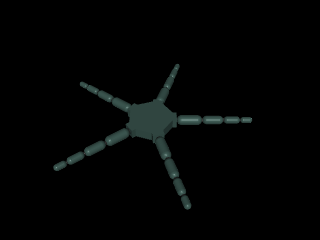

In [6]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=4, use_p_control=True, use_torque_control=False
        )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)

We can also specify a different amount of segments per arm.

""

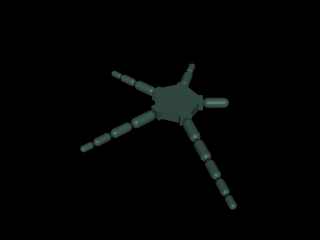

In [7]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=[1, 2, 3, 4, 5], use_p_control=True, use_torque_control=False
        )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)

### 2. Creating the arena
Similarly to the morphology, the next step is to configure and create the AquariumArena in which we will put our brittle star. This arena uses a [simplified fluid model](https://mujoco.readthedocs.io/en/stable/computation/fluid.html#inertia-model) to simulate an aquatic environment.

In [8]:
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena


def create_arena(
        arena_configuration: AquariumArenaConfiguration
        ) -> MJCFAquariumArena:
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    return arena

""

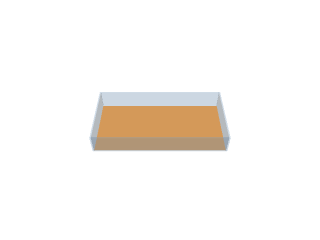

In [9]:
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=True, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
arena = create_arena(arena_configuration=arena_configuration)
visualize_mjcf(mjcf=arena)

### 3. Creating the environment
Now we can create the actual environment that combines the above morphology and arena. As discussed above, we have three different environment versions (each specifying a specific task) in which we can put our brittle star. Each version has a specific EnvironmentConfiguration.

In [10]:
from brb.brittle_star.environment.light.mjc_env import BrittleStarLightEnvironmentConfiguration
from brb.brittle_star.environment.target.mjc_env import BrittleStarTargetEnvironmentConfiguration
from brb.brittle_star.environment.locomotion.mjc_env import BrittleStarLocomotionEnvironmentConfiguration

locomotion_environment_configuration = BrittleStarLocomotionEnvironmentConfiguration(
         # If this value is > 0 then we will add randomly sampled noise to the initial joint positions and velocities 
        joint_randomization_noise_scale=0.0,
        # Visualization mode 
        render_mode="rgb_array",
        # Number of seconds per episode 
        simulation_time=5,
        # Number of physics substeps to do per control step 
        num_physics_steps_per_control_step=10
        )
target_locomotion_environment_configuration = BrittleStarTargetEnvironmentConfiguration(
        # Distance to put our target at (targets are spawned on a circle around the starting location with this given radius).
        target_distance=3.0,
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10
        )
light_escape_environment_configuration = BrittleStarLightEnvironmentConfiguration(
        # If this value is > 0, we will add perlin noise to the generated light map. Otherwise, the light map is a simple linear gradient.
        #   Please only provide integer factors of 200.
        light_perlin_noise_scale=0,
        joint_randomization_noise_scale=0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10
        )

#### Creator
We can now define a function that takes in a certain morphological specification, the arena configuration and the environment configuration and returns the actual environment. Note that we have added an additional argument to this function,`backend`, which can be used to choose between instantiating the MJC (native MuJoCo) or the MJX (JAX-based MuJoCo) implementation of the environment.

This function also accepts a `num_environments` argument, which can be ignored for now. We will discuss this in the 'vectorization' section below.

In [11]:
from mujoco_utils.environment.mjc_env import MJCEnv
from brb.brittle_star.environment.light.mjc_env import BrittleStarLightMJCEnvironment
from brb.brittle_star.environment.target.mjc_env import BrittleStarTargetMJCEnvironment
from brb.brittle_star.environment.locomotion.mjc_env import BrittleStarLocomotionMJCEnvironment
from brb.brittle_star.environment.light.mjx_env import BrittleStarLightMJXEnvironment
from brb.brittle_star.environment.target.mjx_env import BrittleStarTargetMJXEnvironment
from brb.brittle_star.environment.locomotion.mjx_env import BrittleStarLocomotionMJXEnvironment
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration


def create_environment(
        morphology_specification: BrittleStarMorphologySpecification,
        arena_configuration: AquariumArenaConfiguration,
        environment_configuration: MuJoCoEnvironmentConfiguration,
        backend: str,
        num_environments: int = 1
        ) -> Union[MJCEnv, MJXGymEnvWrapper]:
    assert backend in ["MJC", "MJX"], "Please specify a valid backend; Either 'MJC' or 'MJX'"

    def _create_env() -> Union[MJCEnv, gymnasium.vector.AsyncVectorEnv, MJXGymEnvWrapper]:
        morphology = create_morphology(
                morphology_specification=morphology_specification
                )
        arena = create_arena(
                arena_configuration=arena_configuration
                )
        if isinstance(environment_configuration, BrittleStarLocomotionEnvironmentConfiguration):
            env_class = BrittleStarLocomotionMJCEnvironment if backend == "MJC" else BrittleStarLocomotionMJXEnvironment
        elif isinstance(environment_configuration, BrittleStarTargetEnvironmentConfiguration):
            env_class = BrittleStarTargetMJCEnvironment if backend == "MJC" else BrittleStarTargetMJXEnvironment
        else:
            env_class = BrittleStarLightMJCEnvironment if backend == "MJC" else BrittleStarLightMJXEnvironment

        env = env_class(morphology=morphology, arena=arena, configuration=environment_configuration)
        return env

    if backend == "MJC":
        if num_environments > 1:
            return gymnasium.vector.AsyncVectorEnv(
                    [_create_env for _ in range(num_environments)]
                    )
        else:
            return _create_env()
    else:
        # MJXGymEnvWrapper takes care of the handling the consequences of functional programming made necessary by Jax 
        return MJXGymEnvWrapper(env=_create_env(), num_envs=num_environments)

Given the above utility functions, the next code snippet instantiates the environment. 
Use this to test the influence of different parameters and configurations.

""

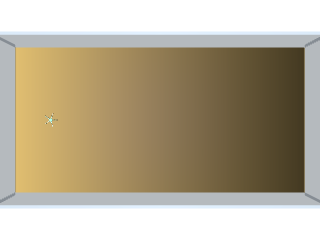

In [12]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=4, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=True, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarLightEnvironmentConfiguration(
        joint_randomization_noise_scale=0.0,
        light_perlin_noise_scale=0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10
        )
env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJC"
        )

env.reset()  # Always need to reset the environment before doing anything else with it
frame = env.render()
media.show_image(post_environment_render(frame, environment_configuration=environment_configuration))
env.close() # always close the environment after using it!

## Using the environment
In this section we will check how we can now actually use the environments. Let's start by instantiating both an MJC and MJX variant.

In [13]:
mjc_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJC"
        )
mjx_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJX"
        )

### Observation space
The observation describes the dimensionality and range of the observations that the environment returns upon reset and after taking a step. As both the MJC and MJX variants implement the same environment, although with a different backend, they have the same observation space.

In [14]:
print(mjc_env.observation_space)
print()
print(mjx_env.observation_space)

Dict('disk_angular_velocity': Box(-inf, inf, (3,), float32), 'disk_linear_velocity': Box(-inf, inf, (3,), float32), 'disk_position': Box(-inf, inf, (3,), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), float32), 'in_plane_joint_position': Box(-0.5235988, 0.5235988, (20,), float32), 'in_plane_joint_velocity': Box(-inf, inf, (20,), float32), 'out_of_plane_joint_position': Box(-0.5235988, 0.5235988, (20,), float32), 'out_of_plane_joint_velocity': Box(-inf, inf, (20,), float32), 'segment_contact': Box(0.0, 1.0, (20,), float32), 'segment_light_intake': Box(0.0, 1.0, (20,), float32))

Dict('disk_angular_velocity': Box(-inf, inf, (3,), float32), 'disk_linear_velocity': Box(-inf, inf, (3,), float32), 'disk_position': Box(-inf, inf, (3,), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), float32), 'in_plane_joint_position': Box(-0.5235988, 0.5235988, (20,), float32), 'in_plane_joint_velocity': Box(-inf, inf, (20,), float32), 'out_of_plane_joint_position': Box(-0.5235988, 0

### Action space
The action space describes the dimensionality and range of actions the environment expects in order to take a step. In essence, the environment maps each given action to the control signal of an actuator.

In [15]:
print(mjc_env.action_space)
print()
print(mjx_env.action_space)

Box(-0.5235988, 0.5235988, (40,), float32)

Box(-0.5235988, 0.5235988, (40,), float32)


To help in knowing which action is mapped to which actuator, the following call returns a list of actuator names such that `actions[i]` is mapped to `actuator[i]`. 

In [16]:
print(mjc_env.actuators)

['BrittleStarMorphology/arm_0_segment_0_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_0_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_2_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_2_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_3_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_3_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_1_segment_0_in_plane_joint_p_control', 'BrittleStarMorphology/arm_1_segment_0_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_1_segment_1_in_plane_joint_p_control', 'BrittleStarMorphology/arm_1_segment_1_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_1_segment_2_in_plane_joint_p_control', 'BrittleStarMorphology/arm_1_segment_2_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_1_segment_3_in_plane

### Running and visualizing an episode
Now we will run the simulation environment and visualize it. As shown below, this happens in a similar manner for both the MJC and the MJX variants, as both follow the [Gymnasium interface](https://gymnasium.farama.org/content/basic_usage/). The only difference is that MJC handles numpy arrays, while MJX handles jax arrays.

TODO: DISCUSS CAMERA_IDS for rendering from different perspectives

#### MJC

In [17]:
done = False
frames = []
obs, info = mjc_env.reset()
while not done:
    actions = mjc_env.action_space.sample()
    obs, reward, terminated, truncated, info = mjc_env.step(actions=actions)
    frame = post_environment_render(mjc_env.render(), environment_configuration=environment_configuration)
    frames.append(frame)
    done = terminated | truncated
media.show_video(images=frames)

#### MJX
Expect this cell to run longer the first time than the MJC variant (this is because the first environment calls trigger a JIT compilation).

In [18]:
done = False
frames = []
obs, info = mjx_env.reset()
while not done:
    actions = jnp.array(mjx_env.action_space.sample())
    obs, reward, terminated, truncated, info = mjx_env.step(actions=actions)
    frame = post_environment_render(mjx_env.render(), environment_configuration=environment_configuration)
    frames.append(frame)
    done = terminated | truncated
media.show_video(images=frames)

Avoid memory leaks and always close your environment after using!

In [19]:
mjc_env.close()
mjx_env.close()

### Vectorization
During optimization we often want multiple environments to run in parallel as this increases data collection speed. For instance with evolutionary optimization, this allows to evaluate multiple candidate solutions in parallel. Alternatively in the reinforcement learning setting, this can be used to simultaneously collect data from slightly different environment versions if we use randomization or noise.

#### MJC
Given its nature, the MJC environment relies on multiprocessing on the CPU. As we conform to the Gymnasium interface, this can be done by using [Gymnasium's AsyncVectorEnv](https://gymnasium.farama.org/api/vector/#async-vector-env). When vectorizing over the CPU, we often use one environment instance for CPU core available. Nevertheless, we can't always expect a linear increase in speed with an increasing number of environment instances. Therefore it is always a good idea to test and compare multiple amounts.

In [20]:
num_environments = 10

morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=4, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=True, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarLightEnvironmentConfiguration(
        # Introduce variability between different instances of the environment
        joint_randomization_noise_scale=0.01,
        light_perlin_noise_scale=10,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10
        )

mjc_vectorized_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend='MJC',
        # Often set to the number of CPU cores available
        num_environments=2
        )

As illustrated below by the adapted `observation_space` and `action_space`, our environment will now return a batched version of the original observations, and expect a batched version of the original actions. Each sample in these batches corresponds to the observations and actions of a single underlying environment.

In [21]:
print(mjc_vectorized_env.observation_space)
print(mjc_vectorized_env.action_space)

Dict('disk_angular_velocity': Box(-inf, inf, (2, 3), float32), 'disk_linear_velocity': Box(-inf, inf, (2, 3), float32), 'disk_position': Box(-inf, inf, (2, 3), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (2, 3), float32), 'in_plane_joint_position': Box(-0.5235988, 0.5235988, (2, 20), float32), 'in_plane_joint_velocity': Box(-inf, inf, (2, 20), float32), 'out_of_plane_joint_position': Box(-0.5235988, 0.5235988, (2, 20), float32), 'out_of_plane_joint_velocity': Box(-inf, inf, (2, 20), float32), 'segment_contact': Box(0.0, 1.0, (2, 20), float32), 'segment_light_intake': Box(0.0, 1.0, (2, 20), float32))
Box(-0.5235988, 0.5235988, (2, 40), float32)


In [22]:
mjc_vectorized_env.close()

#### MJX

The MJX environment can also be vectorized on the CPU, but it's main performance advantage comes from parallelization on the GPU (which JAX enables). MJX basically implements environment / physics steps as operator over big Jax arrays (e.g. an array of all current joint positions, one with all current joint velocities, ...). To parallelize, it just adds an additional batch dimension over these arrays. The [MJXGymEnvWrapper](https://github.com/Co-Evolve/mujoco-utils/blob/new-framework/mujoco_utils/environment/mjx_env.py#L330) implements this for us. When vectorizing over the GPU, we often run one environment instance per CUDA core available (this can be found on your GPU's datasheet). The cool thing is that a single GPU has a lot more of these cores than the number of CPU cores your computer (or even a regular cluster) has. 

As a rule-of-thumb:
- Use MJC when you want to run a single environment (e.g. to do a quick test or to visualize a single rollout).
- Use MJX when you (1) have a GPU available, and (2) are doing an optimization.
- Read: https://mujoco.readthedocs.io/en/stable/mjx.html#mjx-the-sharp-bits

In [24]:
mjx_vectorized_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend='MJX',
        # Set to the available number of GPU CUDA cores (often >1000) 
        num_environments=2
        ) 

In [25]:
print(mjc_vectorized_env.observation_space)
print(mjc_vectorized_env.action_space)

Dict('disk_angular_velocity': Box(-inf, inf, (2, 3), float32), 'disk_linear_velocity': Box(-inf, inf, (2, 3), float32), 'disk_position': Box(-inf, inf, (2, 3), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (2, 3), float32), 'in_plane_joint_position': Box(-0.5235988, 0.5235988, (2, 20), float32), 'in_plane_joint_velocity': Box(-inf, inf, (2, 20), float32), 'out_of_plane_joint_position': Box(-0.5235988, 0.5235988, (2, 20), float32), 'out_of_plane_joint_velocity': Box(-inf, inf, (2, 20), float32), 'segment_contact': Box(0.0, 1.0, (2, 20), float32), 'segment_light_intake': Box(0.0, 1.0, (2, 20), float32))
Box(-0.5235988, 0.5235988, (2, 40), float32)


In [26]:
mjx_vectorized_env.close()